##### Imports

In [12]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding 
from tensorflow.keras.layers import SpatialDropout1D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import os
%matplotlib inline


##### Hyperparameters

In [2]:
# output directory name
output_dir = './output/lstm'

# training
epochs = 4
batch_size = 128

# vector-space embedding
n_dim = 64
n_unique_words = 10000
n_words_to_skip = 50
max_review_length = 100
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# LSTM layer architecture
lstm_rnn = 256
drop_lstm = 0.2

##### Load and Standardize Data

In [4]:
# load data
(x_train, y_train),(x_valid, y_valid) = imdb.load_data(num_words = n_unique_words, 
                       skip_top=n_words_to_skip)

# load word index, add PAD, START, UNK, and reverse k:v
word_index = imdb.get_word_index()
word_index = { k: (v+3) for k,v in word_index.items() }
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2
index_word = { v:k for k,v in word_index.items()}

# Standardize review length with padding
x_train = pad_sequences(x_train,
                        maxlen = max_review_length,
                        padding = pad_type,
                        truncating = trunc_type,
                        value = 0)

x_valid = pad_sequences(x_train,
                        maxlen = max_review_length,
                        padding = pad_type,
                        truncating = trunc_type,
                        value = 0)

##### RNN sentiment classifier architecture

In [ ]:
model = Sequential([
    Embedding(n_unique_words, n_dim, input_length = max_review_length),
    SpatialDropout1D(drop_embed),
    LSTM(lstm_rnn, dropout = drop_lstm),
    Dense(1, activation = 'sigmoid')
])

##### Compile, Checkpoint, and Model Fitting

In [ ]:

model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5')

model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 1,
    validation_data = (x_valid, y_valid),
    callbacks = [model_checkpoint]
)

model.evaluate(x_valid, y_valid, verbose=2)

##### Predict

In [ ]:
# load model parameters from best epoch
model.load_weights(output_dir+"/weights.03.hdf5")

# export for api
model.save(output_dir+'/model.h5')
# with open('pickle/reviews_cnn.pkl', 'wb') as file:
#     pickle.dump(model.tokenizer, file)

prediction_index = 0
predictions = model.predict(x_valid)
predicted_sentiment = predictions[prediction_index][0]

print(predicted_sentiment)
print(' '.join(index_word[id] for id in x_valid[prediction_index]))

print(y_valid[prediction_index])

##### Validation Review

ROC_AUC: 49.49


,y_hat,y
0,0.993270,0
1,0.096851,1
2,0.100946,1
3,0.659015,0
4,0.094035,1
5,0.530045,1
6,0.864065,1
7,0.037972,0
8,0.997774,0
9,0.629321,1


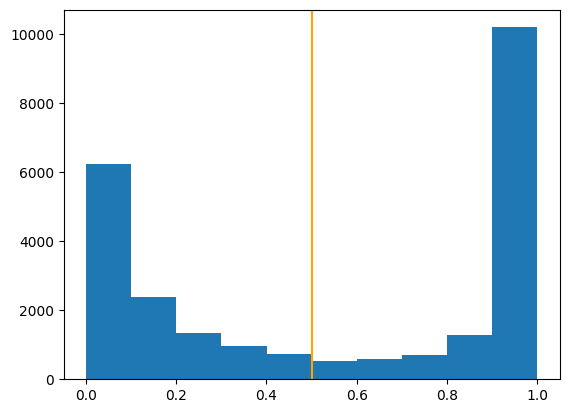

In [9]:
# roc auc score
pct_auc = roc_auc_score(y_valid, predictions)*100.0
print("ROC_AUC: {:0.2f}".format(pct_auc))

# plot predictions
plt.hist(predictions)
_ = plt.axvline(x = 0.5, color = 'orange')

# compare y hat to y
float_y_hat = []
for y in predictions:
    float_y_hat.append(y[0])

ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns = ['y_hat', 'y'])
ydf.head(10)

##### False Positives

In [10]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)

,y_hat,y
0,0.993270,0
8,0.997774,0
19,0.977932,0
32,0.951936,0
33,0.980262,0
46,0.989851,0
48,0.991641,0
58,0.998466,0
59,0.971466,0
63,0.936068,0


##### False Negatives

In [11]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)

,y_hat,y
1,0.096851,1
4,0.094035,1
14,0.099636,1
20,0.005805,1
23,0.013543,1
30,0.067901,1
43,0.081365,1
49,0.008463,1
55,0.045379,1
71,0.045852,1
